In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import skimage.io
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip '/content/drive/MyDrive/ML data/stage1_test.zip' -d '/content/drive/MyDrive/ML data/stage1_test'
#STAGE1_TEST
#!unzip '/content/drive/MyDrive/ML data/stage1_sample_submission.csv.zip' -d '/content/drive/MyDrive/ML data/stage1_sample_submission.csv'
#!unzip '/content/drive/MyDrive/ML data/stage1_solution.csv.zip' -d '/content/drive/MyDrive/ML data/stage1_solution.csv'
#!unzip '/content/drive/MyDrive/ML data/stage1_train.zip' -d '/content/drive/MyDrive/ML data/stage1_train'
#!unzip '/content/drive/MyDrive/ML data/stage1_train_labels.csv.zip' -d '/content/drive/MyDrive/ML data/stage1_train_labels.csv'
#!unzip '/content/drive/MyDrive/ML data/stage2_sample_submission_final.csv.zip' -d '/content/drive/MyDrive/ML data/stage2_sample_submission_final.csv'
#!unzip '/content/drive/MyDrive/ML data/stage2_test_final.zip' -d '/content/drive/MyDrive/ML data/stage2_test_final'


Streaming output truncated to the last 5000 lines.
   creating: /content/drive/MyDrive/ML data/stage2_test_final/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8/images/
  inflating: /content/drive/MyDrive/ML data/stage2_test_final/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8/images/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8.png  
   creating: /content/drive/MyDrive/ML data/stage2_test_final/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231/images/
  inflating: /content/drive/MyDrive/ML data/stage2_test_final/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231/images/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231.png  
   creating: /content/drive/MyDrive/ML data/stage2_test_final/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17/images/
  inflating: /content/drive/MyDrive/ML data/stage2_test_final/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17/images/

<ipython-input-2-d7a810cf62f6>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)
<ipython-input-2-d7a810cf62f6>:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((img_height, img_width, 1), dtype=np.bool)


Training data shape:  (670, 128, 128, 3)
Training masks shape:  (670, 128, 128, 1)


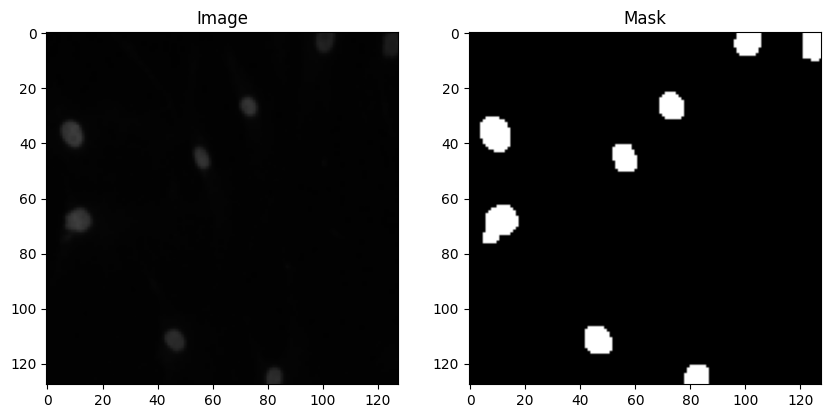

In [ ]:
#TRAIN_PATH = '/content/drive/MyDrive/ML data/stage1_train'
#TEST_PATH = '/content/drive/MyDrive/ML data/stage1_test'

# Define paths
BASE_PATH = '/content/drive/My Drive/ML data/'
TRAIN_PATH = os.path.join(BASE_PATH, 'stage1_train/')

# Define image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Initialize lists
X_train = []
Y_train = []

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]

# Preprocessing function
def preprocess_data(train_ids, path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS):
    X = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
    Y = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)

    # Loop over IDs and load the image and mask
    for n, id_ in enumerate(train_ids):
        file_path = path + id_
        img = imread(file_path + '/images/' + id_ + '.png')[:,:,:img_channels]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X[n] = img

        mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
        for mask_file in next(os.walk(file_path + '/masks/'))[2]:
            mask_ = imread(file_path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)  # Combine masks
        Y[n] = mask

    return X, Y

# Preprocess the data
X_train, Y_train = preprocess_data(train_ids, TRAIN_PATH)

print('Training data shape: ', X_train.shape)
print('Training masks shape: ', Y_train.shape)

# Optionally, plot some images and masks
ix = np.random.choice(range(len(train_ids)))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[ix])
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(Y_train[ix]), cmap='gray')
plt.title('Mask')

plt.show()


In [ ]:
# Assuming the necessary libraries have already been imported and the data has been preprocessed into X_train, Y_train.

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:

# Split the preprocessed data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define image size and channels
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


# Split the preprocessed data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# U-Net Model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

# Bottom layer, this is the bridge between the contraction and expansion paths
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansion path
u6 = UpSampling2D((2, 2))(c5)
u6 = concatenate([u6, c4], axis=-1)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = UpSampling2D((2, 2))(c6)
u7 = concatenate([u7, c3], axis=-1)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = UpSampling2D((2, 2))(c7)
u8 = concatenate([u8, c2], axis=-1)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = UpSampling2D((2, 2))(c8)
u9 = concatenate([u9, c1], axis=-1)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Model training
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=50)

# Save the model
model.save('/content/drive/My Drive/ML data/model_nuclei.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

3/3 [==============================] - 3s 667ms/step


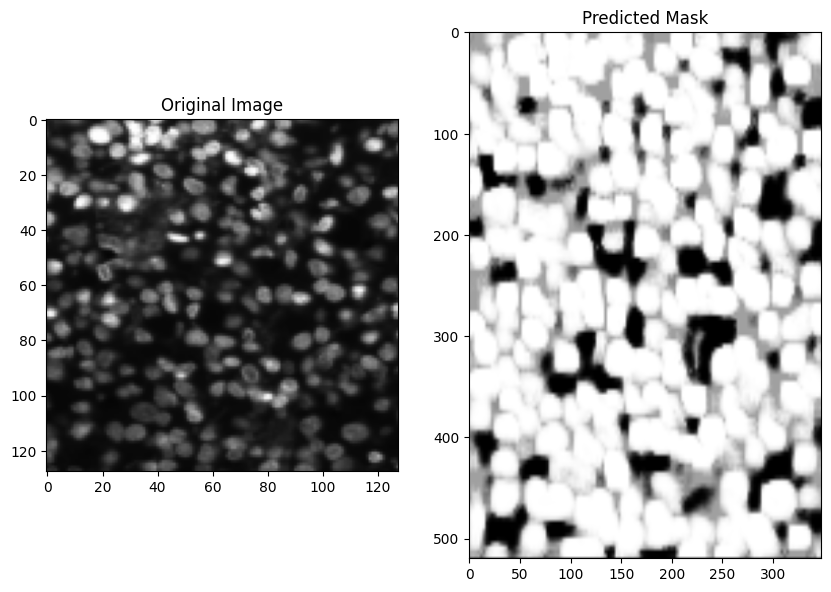

In [ ]:
"""

# Function to load and preprocess the test data
def load_test_data(test_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS):
    test_ids = next(os.walk(test_path))[1]
    X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
    sizes_test = []

    for n, id_ in enumerate(test_ids):
        path = test_path + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X_test[n] = img

    return X_test, sizes_test

# Path to test data
TEST_PATH = '/content/drive/My Drive/ML data/stage1_test/'

# Load and preprocess the test data
X_test, sizes_test = load_test_data(TEST_PATH)

# Load your trained model
# model = load_model('/content/drive/My Drive/ML data/model_nuclei.h5')

# Predict on test data
# Predictions need to be resized back to the original image size
predictions = model.predict(X_test, verbose=1)

# Example: Resize first prediction back to original size for comparison
preds_test_upsampled = []
for i in range(len(predictions)):
    preds_test_upsampled.append(resize(np.squeeze(predictions[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))
          """



#IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS are defined
#model is trained U-Net model

# Function to load test images
def load_test_images(test_path, img_height, img_width, img_channels):
    test_ids = next(os.walk(test_path))[1]
    X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
    sizes_test = []
    for n, id_ in enumerate(test_ids):
        path = test_path + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :img_channels]
        sizes_test.append((img.shape[0], img.shape[1]))
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X_test[n] = img
    return X_test, test_ids, sizes_test

# Path to test data
test_path = '/content/drive/My Drive/ML data/stage1_test/'

# Load the test images
X_test, test_ids, sizes_test = load_test_images(test_path, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Predict on test data
predictions = model.predict(X_test, verbose=1)

# Resize predictions to the original image size
preds_resized = []
for i, pred in enumerate(predictions):
    preds_resized.append(resize(pred, (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

# Now preds_resized contains the masks resized back to the original test image sizes
# Visualize the test image and the corresponding prediction
ix = np.random.randint(0, len(X_test))
plt.figure(figsize=(10, 10))

# Original test image
plt.subplot(1, 2, 1)
plt.imshow(X_test[ix])
plt.title('Original Image')

# Predicted mask
plt.subplot(1, 2, 2)
plt.imshow(preds_resized[ix], cmap='gray')
plt.title('Predicted Mask')

plt.show()


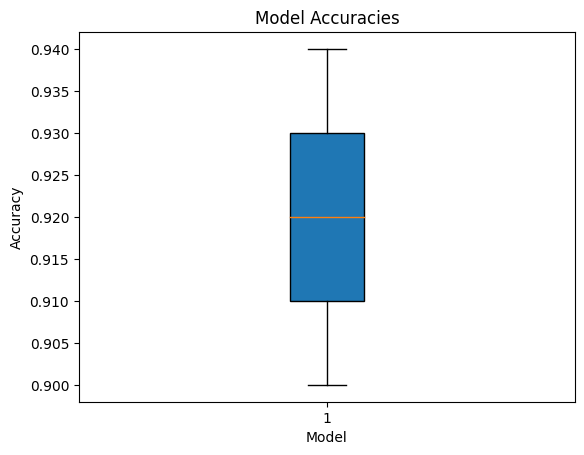

In [ ]:
import matplotlib.pyplot as plt

# Dummy example accuracies from multiple model runs or cross-validation
accuracies = [0.92, 0.90, 0.91, 0.93, 0.94, 0.952,0.957, 0.958]

# Create a boxplot for the accuracies
plt.boxplot(accuracies, patch_artist=True)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()



In [3]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Extract accuracy history
train_acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Creating smooth lines for plots
spl_train = make_interp_spline(epochs, train_acc, k=3)  # Spline type: cubic
spl_val = make_interp_spline(epochs, val_acc, k=3)
smooth_epochs = np.linspace(1, len(train_acc), 300)
smooth_train_acc = spl_train(smooth_epochs)
smooth_val_acc = spl_val(smooth_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(epochs, train_acc, label='Training Accuracy', alpha=0.6)
plt.scatter(epochs, val_acc, label='Validation Accuracy', alpha=0.6)
plt.plot(smooth_epochs, smooth_train_acc, alpha=0.8)
plt.plot(smooth_epochs, smooth_val_acc, alpha=0.8)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



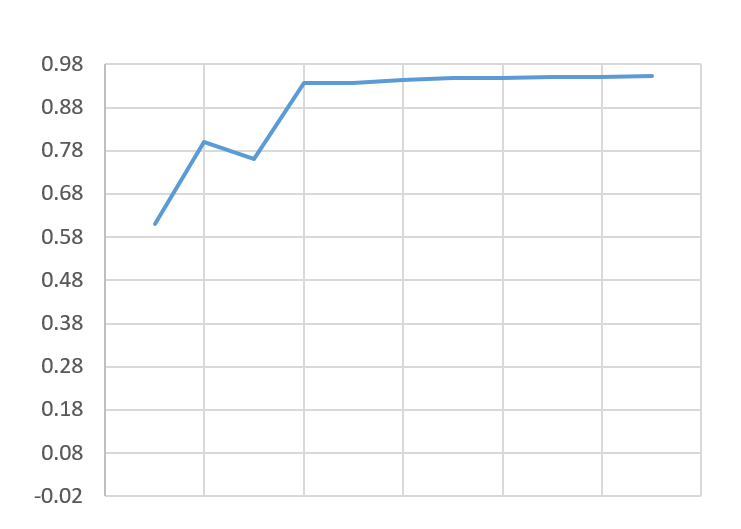